In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import dask.array as da
# from dask.array.image import imread
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=2)
sns.set_style("white")
import h5py
%load_ext autoreload
%autoreload 2
import gc

import os, sys
fish_path = os.path.abspath(os.path.join('..'))
if fish_path not in sys.path:
    sys.path.append(fish_path)

from utils.memory import get_process_memory
print('Initial memory use:')
get_process_memory();

RAM used 0.1176 GB


### Load data

In [2]:
# folderName = '/nrs/ahrens/Takashi/06152017Fish1-2'
fishName = '06152017Fish1-2'
# imgFileName = 'registered.tif'
# imgFile = os.path.join(folderName, imgFileName)
# imgStack = imread(imgFile)
# print(imgStack.shape)
# # check the first image
# plt.imshow(imgStack[0, 0, :, :], cmap='gray')
# plt.axis('off')
# plt.show()

## 1. Pixel Denoising
## 2. Motion correction

### Above is done by TK

In [3]:
# Y = imgStack.squeeze(axis=0)
# Y = Y.transpose([1, 2, 0])
# chunk_size = (Y.shape[0]//4, Y.shape[0]//8)
# Y = Y.rechunk((chunk_size[0], chunk_size[1], -1))
# da.to_hdf5('tmpData/%s-dat.hdf5'%(fishName), '/Raw', Y)

In [4]:
f = h5py.File('tmpData/%s-dat.hdf5'%(fishName)) # HDF5 file
Y = f['/Raw'] 

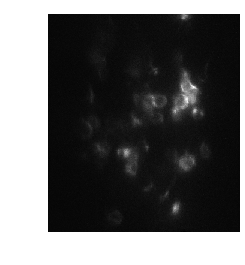

In [7]:
plt.imshow(Y[:, :, 0], cmap='gray')
plt.axis('off')
plt.show()

In [9]:
print('Memory use for loading a image:')
get_process_memory();

Memory use for loading a image:
RAM used 0.1249 GB


## 3. Local pca -- spatial denoising

### 3.1. Detrend corrected signal on pixels

In [17]:
from denoiseLocalPCA.detrend import detrend

In [15]:
y_ = Y[:10, :10, :]
# Y_detr, trend, _, _ = detrend(Y)
# np.save('tmpData/%s_Y_detr'%(fishName), Y_detr)
# np.save('tmpData/%s_Y_trend'%(fishName), trend)

In [20]:
y_detr, trend, _, _ = detrend(y_)

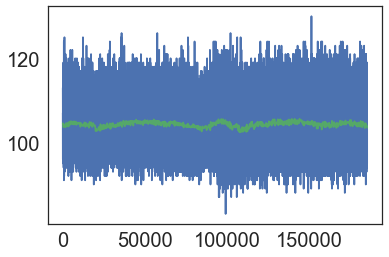

In [21]:
plt.plot(y_[0,0,:])
plt.plot(trend[0,0,:])
plt.show()

In [23]:
import multiprocessing as mp
mp.cpu_count()

16

## 4. Demix